In [ ]:
!pip install pylhe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.0/864.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.4/636.4 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 13.1 MB/s eta 0:00:00


# another

In [ ]:
import pylhe
realback = '/content/hope2.lhe'
#events_realback = pylhe.read_lhe_with_attributes(realback)
events_realback = list(pylhe.read_lhe_with_attributes(realback))  # Convert generator to list
'''
midpoint = len(events_realback) // 2

# Split the events into two parts
part1 = events_realback[:midpoint]
part2 = events_realback[midpoint:]
'''

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

loss_of_model = []
epoch_n = []
# Initialize lists to store 4-momentum of muons and antimuons
b_momentum = []
antib_momentum = []

# Loop through events and particles
for event in events_realback:
    for particle in event.particles:
        if particle.id == 5:  #
            b_momentum.append([particle.e, particle.px, particle.py, particle.pz])
        elif particle.id == -5:
            antib_momentum.append([particle.e, particle.px, particle.py, particle.pz])

# Convert lists to NumPy arrays
combined_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(b_momentum, antib_momentum)]
combined_list = np.array(combined_list)
# Assuming combined_list is your input data

mean = np.mean(combined_list, axis=0)
std = np.std(combined_list, axis=0)

# Normalize the data
normalized_data = (combined_list - mean) / std

# Now split the normalized data into train and test sets
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)


# Convert NumPy arrays to PyTorch tensors with float32 type
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
# 8>128>64>2
# Define the Autoencoder class
#8>64>32>4>32>64>8.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(8, 128),  # Compress from 8 features to 4
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)

        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 8)  # Reconstruct back to 8 features
        )

    def forward(self, x):
        # Encode the input
        x = self.encoder(x)
        # Decode the encoded representation
        x = self.decoder(x)
        return x

# Create the autoencoder model
model = Autoencoder()

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.015)

# Training loop
for epoch in range(500):  # Loop for 100 epochs

    model.train()  # Set model to training mode
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass
    output = model(train_tensor)
    # Compute the loss
    loss = criterion(output, train_tensor)
    # Backward pass
    loss.backward()
    # Update the weights
    optimizer.step()

    # Evaluate the model on the test set every 10 epochs

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        test_output = model(test_tensor)
        test_loss = criterion(test_output, test_tensor)
        epoch_n.append(epoch)
        #print(f'Epoch [{epoch+1}/100], Test Loss: {test_loss.item():.4f}')
    output_array = test_output.detach().numpy()
    input_array = test_tensor.detach().numpy()
    output_array, input_array = output_array*std+mean, input_array*std +mean
    error = ((output_array[:, 0] + output_array[:, 4] - input_array[:, 0] - input_array[:, 4])**2 +
            (output_array[:, 1] + output_array[:, 5] - input_array[:, 1] - input_array[:, 5])**2 +
            (output_array[:, 2] + output_array[:, 6] - input_array[:, 2] - input_array[:, 6])**2 +
            (output_array[:, 3] + output_array[:, 7] - input_array[:, 3] - input_array[:, 7])**2)
    error_mean = np.mean(error)
    loss_of_model.append(error_mean)



In [ ]:
model.summary()

AttributeError: 'Autoencoder' object has no attribute 'summary'

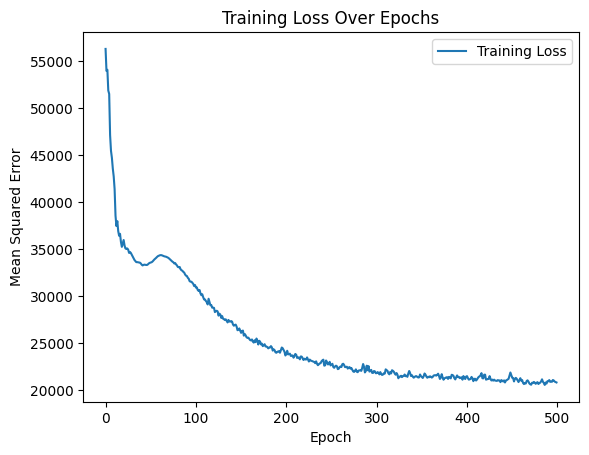

In [ ]:
import pylhe
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and process the data
realback = '/content/hope2.lhe'
events_realback = list(pylhe.read_lhe_with_attributes(realback))

b_momentum = []
antib_momentum = []

for event in events_realback:
    for particle in event.particles:
        if particle.id == 5:
            b_momentum.append([particle.e, particle.px, particle.py, particle.pz])
        elif particle.id == -5:
            antib_momentum.append([particle.e, particle.px, particle.py, particle.pz])

combined_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(b_momentum, antib_momentum)]
combined_list = np.array(combined_list)

mean = np.mean(combined_list, axis=0)
std = np.std(combined_list, axis=0)
normalized_data = (combined_list - mean) / std

train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the autoencoder model
model = Autoencoder()


# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.015)

# Training loop
loss_of_model = []
epoch_n = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(train_tensor)
    loss = criterion(output, train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_output = model(test_tensor)
        test_loss = criterion(test_output, test_tensor)
        epoch_n.append(epoch)
        output_array = test_output.detach().numpy()
        input_array = test_tensor.detach().numpy()
        output_array, input_array = output_array * std + mean, input_array * std + mean
        error = ((output_array[:, 0] + output_array[:, 4] - input_array[:, 0] - input_array[:, 4])**2 +
                 (output_array[:, 1] + output_array[:, 5] - input_array[:, 1] - input_array[:, 5])**2 +
                 (output_array[:, 2] + output_array[:, 6] - input_array[:, 2] - input_array[:, 6])**2 +
                 (output_array[:, 3] + output_array[:, 7] - input_array[:, 3] - input_array[:, 7])**2)
        error_mean = np.mean(error)
        loss_of_model.append(error_mean)

# Plot the training loss over epochs
plt.plot(epoch_n, loss_of_model, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

<ipython-input-144-3cf674f4f2ea>:6: RuntimeWarning: invalid value encountered in sqrt
  mass = mass**0.5


368.33290552460966


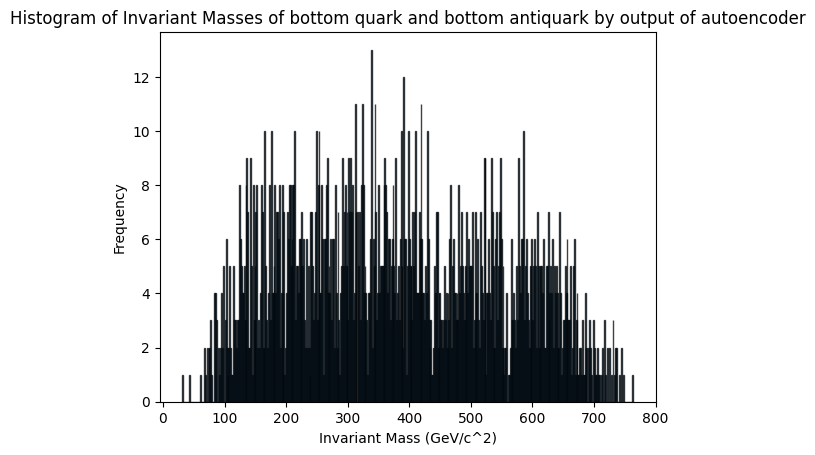

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mass = (output_array[:, 0]+output_array[:, 4])**2-(output_array[:, 1] + output_array[:, 5])**2-(output_array[:, 2] + output_array[:, 6])**2-(output_array[:, 3] + output_array[:, 7])**2
median = np.median(mass)**0.5
mass = mass**0.5
# Create a histogram
plt.hist(mass, bins=500, alpha=0.75, edgecolor='black')

# Add titles and labels
plt.xlabel('Invariant Mass (GeV/c^2)')
plt.ylabel('Frequency')
plt.title('Histogram of Invariant Masses of bottom quark and bottom antiquark by output of autoencoder')

print(median)

# Show the plot
plt.show()

# back

In [ ]:


ano = '/content/ano.lhe'
events_ano = pylhe.read_lhe_with_attributes(ano)
import itertools


realback = '/content/hope2.lhe'
#events_realback = pylhe.read_lhe_with_attributes(realback)
events_realback = list(pylhe.read_lhe_with_attributes(realback))  # Convert generator to list
'''
midpoint = len(events_realback) // 2

# Split the events into two parts
part1 = events_realback[:midpoint]
part2 = events_realback[midpoint:]
'''
import torch
import numpy as np
b_momentum = []
antib_momentum = []

# Loop through events and particles
#for event in events_realback:
for event in events_realback:
    for particle in event.particles:
        if particle.id == 5:  # Muon
            b_momentum.append([particle.e, particle.px, particle.py, particle.pz])
        elif particle.id == -5:  # Antimuon
            antib_momentum.append([particle.e, particle.px, particle.py, particle.pz])

# Convert lists to NumPy arrays
combined_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(b_momentum, antib_momentum)]
combined_list = np.array(combined_list)
# Assuming `new_data` is your new input data

mean = np.mean(combined_list, axis=0)
std = np.std(combined_list, axis=0)

# Normalize the new data
input_array = combined_list
normalized_new_data = (input_array - mean) / std

# Convert to PyTorch tensor
new_data_tensor = torch.tensor(normalized_new_data, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():  # Disable gradient computation
    reconstructed_output = model(new_data_tensor)

# Convert the output back to NumPy array
output_array = reconstructed_output.detach().numpy()

# Denormalize the output
output_array = output_array * std + mean
error_back = ((output_array[:, 0] + output_array[:, 4] - input_array[:, 0] - input_array[:, 4])**2 +
        (output_array[:, 1] + output_array[:, 5] - input_array[:, 1] - input_array[:, 5])**2 +
        (output_array[:, 2] + output_array[:, 6] - input_array[:, 2] - input_array[:, 6])**2 +
        (output_array[:, 3] + output_array[:, 7] - input_array[:, 3] - input_array[:, 7])**2)


In [ ]:
print(len(error_back))
print(np.mean(error_back))

10000
5742.719155659347


# ano

In [ ]:
realback = '/content/hope2.lhe'
events_realback = pylhe.read_lhe_with_attributes(realback)
ano = '/content/ano.lhe'
events_ano = pylhe.read_lhe_with_attributes(ano)
import itertools
combined_events = itertools.chain(events_realback, events_ano)



import torch
import numpy as np
b_momentum = []
antib_momentum = []

# Loop through events and particles
for event in events_ano:
    for particle in event.particles:
        if particle.id == 5:  # Muon
            b_momentum.append([particle.e, particle.px, particle.py, particle.pz])
        elif particle.id == -5:  # Antimuon
            antib_momentum.append([particle.e, particle.px, particle.py, particle.pz])

# Convert lists to NumPy arrays
combined_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(b_momentum, antib_momentum)]
combined_list = np.array(combined_list)
# Assuming `new_data` is your new input data

mean = np.mean(combined_list, axis=0)
std = np.std(combined_list, axis=0)

# Normalize the new data
input_array = combined_list
normalized_new_data = (input_array - mean) / std

# Convert to PyTorch tensor
new_data_tensor = torch.tensor(normalized_new_data, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():  # Disable gradient computation
    reconstructed_output = model(new_data_tensor)

# Convert the output back to NumPy array
output_array = reconstructed_output.detach().numpy()

# Denormalize the output
output_array = output_array * std + mean
error_ano = ((output_array[:, 0] + output_array[:, 4] - input_array[:, 0] - input_array[:, 4])**2 +
        (output_array[:, 1] + output_array[:, 5] - input_array[:, 1] - input_array[:, 5])**2 +
        (output_array[:, 2] + output_array[:, 6] - input_array[:, 2] - input_array[:, 6])**2 +
        (output_array[:, 3] + output_array[:, 7] - input_array[:, 3] - input_array[:, 7])**2)


In [ ]:
print(np.mean(error_ano),np.std(error_ano))

120257.13350065485 113921.43529989176


# mix

In [ ]:
import random
realback = '/content/hope2.lhe'
events_realback = list(pylhe.read_lhe_with_attributes(realback))  # Convert generator to list
ano = '/content/ano.lhe'
events_ano = list(pylhe.read_lhe_with_attributes(ano))  # Convert generator to list

# Determine the total number of events
total_realback = len(events_realback)
total_ano = len(events_ano)

# Calculate the number of events to sample (80% from realback, 20% from ano)
num_realback = int(0.8 * total_realback)
num_ano = int(0.2 * total_ano)

# Randomly sample events (ensure that the number of events is not greater than available events)
sampled_realback = random.sample(events_realback, min(num_realback, total_realback))
sampled_ano = random.sample(events_ano, min(num_ano, total_ano))

# Combine the sampled events
combined_events = sampled_realback + sampled_ano


import torch
import numpy as np
b_momentum = []
antib_momentum = []

# Loop through events and particles
for event in combined_events:
    for particle in event.particles:
        if particle.id == 5:  # Muon
            b_momentum.append([particle.e, particle.px, particle.py, particle.pz])
        elif particle.id == -5:  # Antimuon
            antib_momentum.append([particle.e, particle.px, particle.py, particle.pz])

# Convert lists to NumPy arrays
combined_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(b_momentum, antib_momentum)]
combined_list = np.array(combined_list)
# Assuming `new_data` is your new input data

mean = np.mean(combined_list, axis=0)
std = np.std(combined_list, axis=0)

# Normalize the new data
input_array = combined_list
normalized_new_data = (input_array - mean) / std

# Convert to PyTorch tensor
new_data_tensor = torch.tensor(normalized_new_data, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():  # Disable gradient computation
    reconstructed_output = model(new_data_tensor)

# Convert the output back to NumPy array
output_array = reconstructed_output.detach().numpy()

# Denormalize the output
output_array = output_array * std + mean
error_mix = ((output_array[:, 0] + output_array[:, 4] - input_array[:, 0] - input_array[:, 4])**2 +
        (output_array[:, 1] + output_array[:, 5] - input_array[:, 1] - input_array[:, 5])**2 +
        (output_array[:, 2] + output_array[:, 6] - input_array[:, 2] - input_array[:, 6])**2 +
        (output_array[:, 3] + output_array[:, 7] - input_array[:, 3] - input_array[:, 7])**2)


In [ ]:
print(len(error_mix))


10000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
'''
error_mix1 = [x for x in error_mix if 0 <= x <= 50000]
error_ano1 = [x for x in error_ano if 0 <= x <= 50000]
'''
plt.hist(error_back, bins=90, alpha=0.5,color = 'red', label='background')
#plt.hist(error_mix, bins=250, alpha=0.5,color = 'blue' ,label='mix')
plt.xlim(0, 500000)  # Adjust the x-axis range
#plt.ylim(0, 50)  # Adjust the y-axis range
# Adding labels and legend
plt.xlabel('error')
plt.ylabel('count')
plt.title('Reconstruction error of muon and anti-muon')
plt.legend()

# Show plot
plt.show()

NameError: name 'error_back' is not defined

# 2 plot

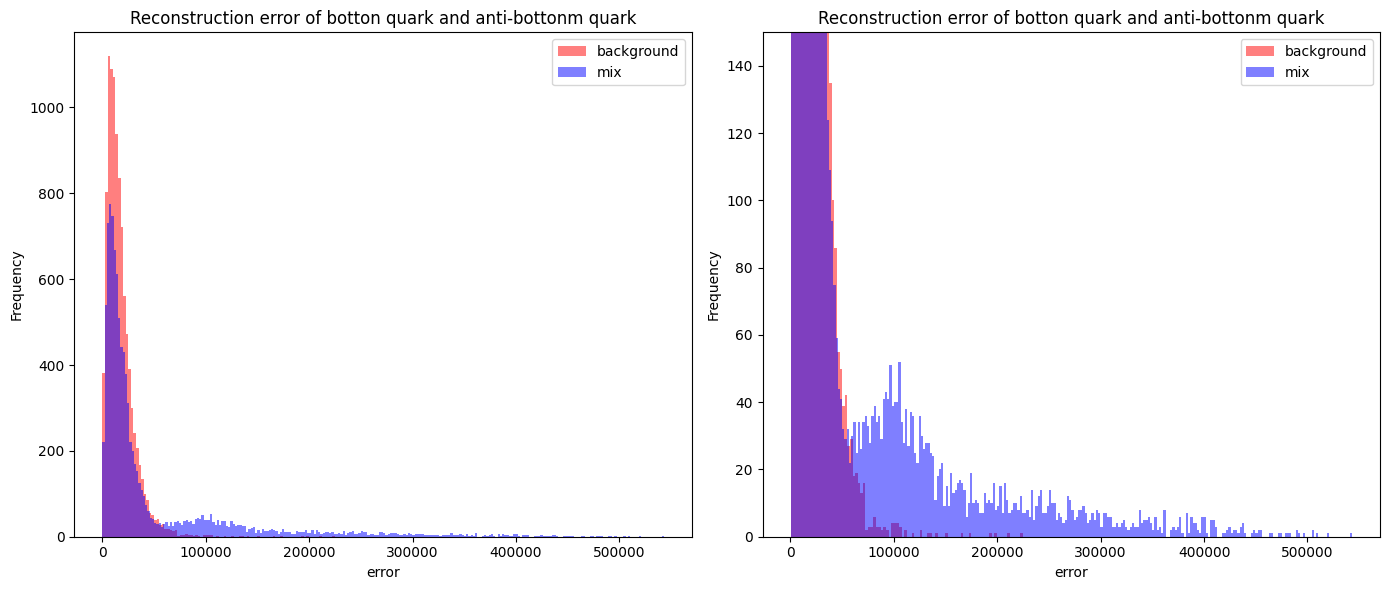

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on the first subplot without plt.ylim(0, 150)
ax1.hist(error_back, bins=90, alpha=0.5, color='red', label='background')
ax1.hist(error_mix, bins=250, alpha=0.5, color='blue', label='mix')
#ax1.set_xlim(0, 30000)
ax1.set_xlabel('error')
ax1.set_ylabel('Frequency')
ax1.set_title('Reconstruction error of botton quark and anti-bottonm quark')
ax1.legend()

# Plot on the second subplot with plt.ylim(0, 150)
ax2.hist(error_back, bins=90, alpha=0.5, color='red', label='background')
ax2.hist(error_mix, bins=250, alpha=0.5, color='blue', label='mix')
#ax2.set_xlim(0, 30000)
ax2.set_ylim(0, 150)
ax2.set_xlabel('error')
ax2.set_ylabel('Frequency')
ax2.set_title('Reconstruction error of botton quark and anti-bottonm quark')
ax2.legend()

# Show plot
plt.tight_layout()
plt.show()